In [1]:
#Import necessary packages

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd # don't think we are actually using pandas

matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
from __future__ import print_function
from PYME.recipes import modules # this import seems needed to avoid errors when running the recipe below

from PYME.LMVis import pipeline as pl
from PYME.recipes import tracking,localisations,base;
from PYMEcs.misc.utils import pyme_logging_filter

pyme_logging_filter() # supress a few minor warnings


data = pl.Pipeline("../Biplane QE-PAINT_pig tissue/pig_tissue_biplane_RyR_IP3R_ExchangePAINT.hdf")

In [2]:

data.recipe.update_from_yaml("fiducial_driftcorrection recipe.yaml")                             



print("Current data source: %s" % data.selectedDataSourceKey) # what is the currently selected data source
print("Available data sources: %s" % ', '.join(data.dataSources.keys())) # look at all the data sources we could select

data.selectDataSource('timedSpecies')
print("Number of events in data source timespecies is %d" % data.x.size)

Current data source: filtered_localizations
Available data sources: _Localizations, FitResults, Localizations, colour_mapped, filtered_localizations, Fiducials, fiducialAdded, fiducialApplied, corrected_fiducials, timedSpecies
Number of events in data source timespecies is 465978


In [3]:
tb = tracking.FindClumps(inputName='timedSpecies', outputName= 'with_clumps', timeWindow=5)
data.recipe.add_module(tb)
dm = localisations.MergeClumps(inputName='with_clumps', outputName= 'coalesced')
data.recipe.add_module(dm)
data.recipe.execute()

Current data source: coalesced


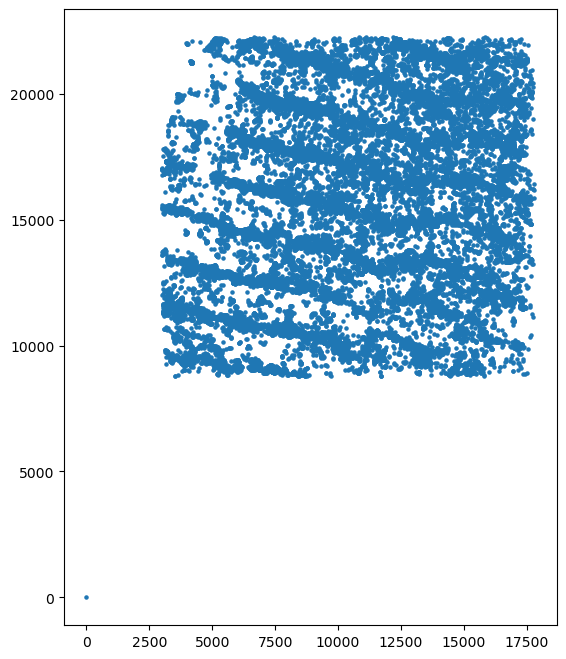

In [4]:
data.selectDataSource('coalesced')
print("Current data source: %s" % data.selectedDataSourceKey) # what is the currently selected data source
plt.subplot(aspect='equal') # we are trying to get the plot aspect ratio to be correct
plt.scatter(data.x,data.y,s=5)

### Making a new recipe module in a notebook

Below we make quite a simple recipe module. This can be useful to experiment with making and validating new recipe modules in a Jupyter notebook before integration into one's plugin library. This requires inserting our new module into the recipe programmatically as shown below. Only once you have the module in your plugin repo and registered it with PYME as illustrated in the [PYME template plugin repo](https://github.com/python-microscopy/pyme-plugin) can you use it from PYMEVis and other PYME GUI apps.

In [5]:
from PYME.recipes.base import register_module, ModuleBase, Filter
from PYME.recipes.traits import Input, Output, Float, Enum, CStr, Bool, Int, List, DictStrStr, DictStrList, ListFloat, ListStr, FileOrURI

# import numpy as np
# import pandas as pd
from PYME.IO import tabular

@register_module('StretchX')
class StretchX(ModuleBase):
    """Simple module to test the concept"""
    inputName = Input('localisations')
    outputName = Output('stretched')

    # below we do something fairly unspectacular but it is sufficient to illustrate the idea
    def run(self, inputName):
        mapped_ds = tabular.MappingFilter(inputName)
        mapped_ds.setMapping('x_ori', 'x') # we remember the original x
        mapped_ds.setMapping('x', '2*x')   # and stretch the original x two-fold
        return mapped_ds

In [6]:
idm = StretchX(data.recipe,inputName='timedSpecies',
                outputName='tS_stretch')
data.recipe.add_module(idm)
data.recipe.execute()

In [7]:
data.selectDataSource('tS_stretch')

In [8]:
np.all(data['x'] == 2*data['x_ori']) # this should now be true

True

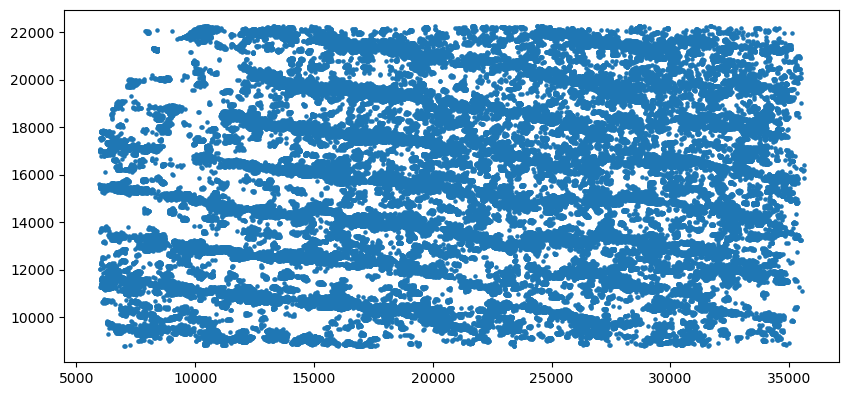

In [9]:
plt.subplot(aspect='equal') # we are trying to get the plot aspect ratio to be correct
plt.scatter(data.x,data.y,s=5) # let's look at the stretched coordinates